In [1]:
import numpy as np
import struct

In [2]:
file_path = "./storage/mc_run_data.dat"
sample_size = 8
with open(file_path, 'rb') as f:
    # Read the binary data
    binary_data = f.read()

num_samples = len(binary_data) // sample_size
samples = []
for i in range(num_samples):
    # Extract real and imaginary parts from the binary data
    real_part, imag_part = struct.unpack('ff', binary_data[i * sample_size: (i + 1) * sample_size])
    # Create a complex number and append it to the list of samples
    samples.append(complex(real_part, imag_part))

samples = np.array(samples)
samples.shape

(6120,)

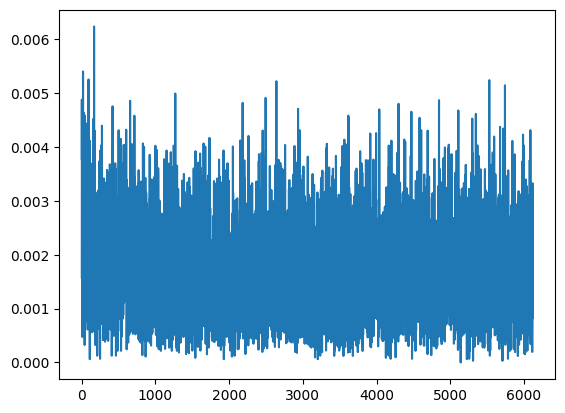

In [3]:
from matplotlib import pyplot as plt
plt.plot(np.abs(samples))

In [4]:
N = 257
M_list = [41, 73, 109, 97, 173, 211, 139]

zfc_seq_list = [np.array([np.exp(-1j * np.pi * M * n * (n + 1) / N) for n in range(N)]) for M in M_list]


In [5]:

corr_zfc_list = [np.correlate(samples, zfc_seq, mode='full') / N for zfc_seq in zfc_seq_list]

peak_indices = []
for i in range(len(M_list)):
    peak_indices.append(np.argmax(np.abs(corr_zfc_list[i])).item())

print(peak_indices)


[4281, 1697, 1490, 520, 758, 774, 5204]


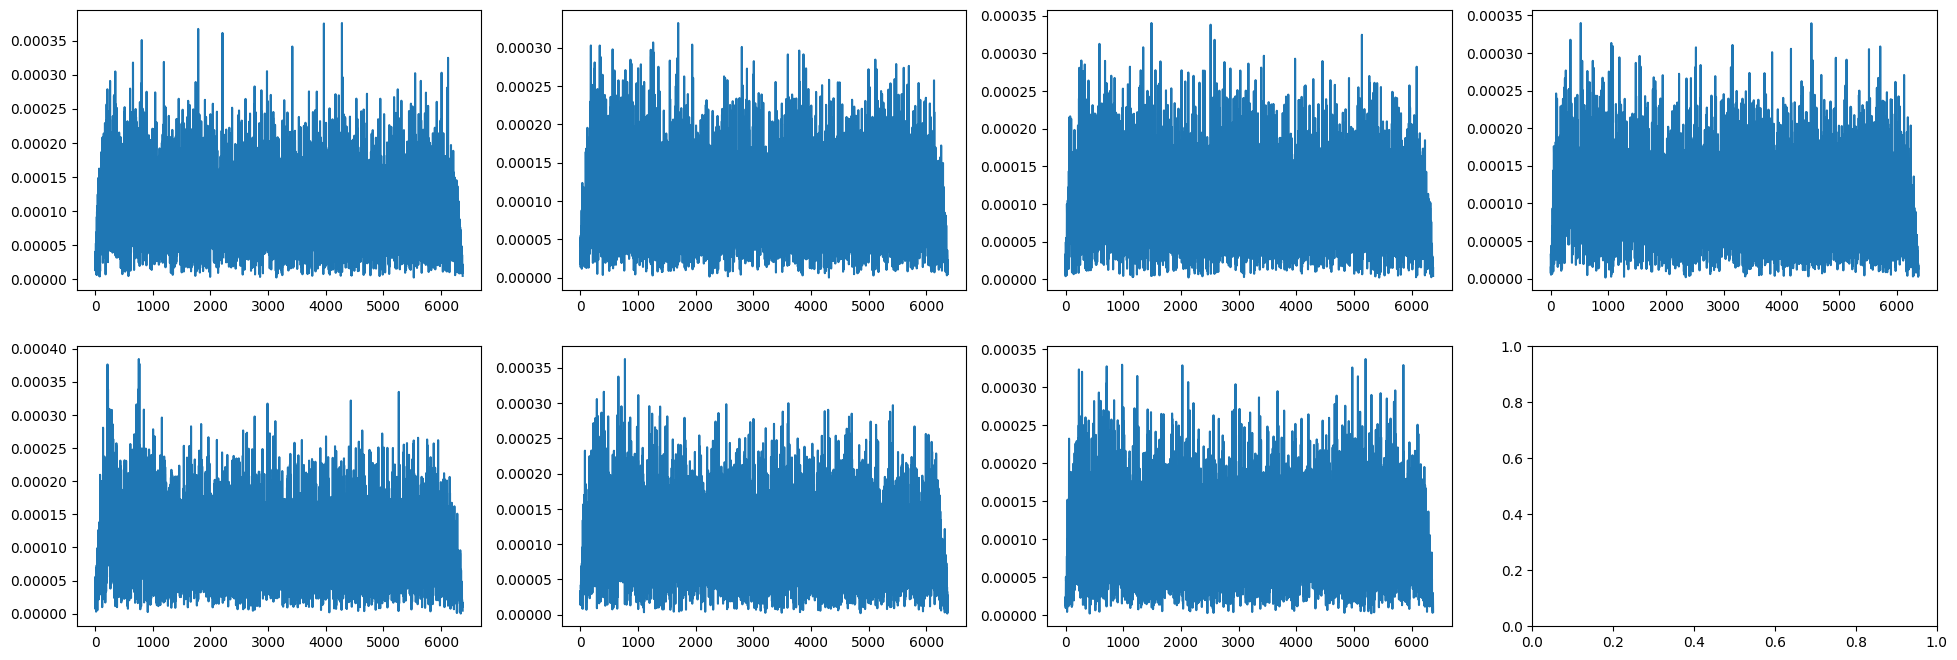

In [7]:
plot_data_list = [np.abs(corr_zfc) for corr_zfc in corr_zfc_list]

fig, ax = plt.subplots(2, 4, figsize=[24,8])
axs = ax.flatten()
for i in range(len(M_list)):
    axs[i].plot(plot_data_list[i])

# print(np.diff(np.argwhere(plot_data > 60.0).squeeze()))
# print(plot_data[np.argwhere(plot_data > 60.0).squeeze()])


0.031927373661379974
0.004675075713641289
0.00213184144996236


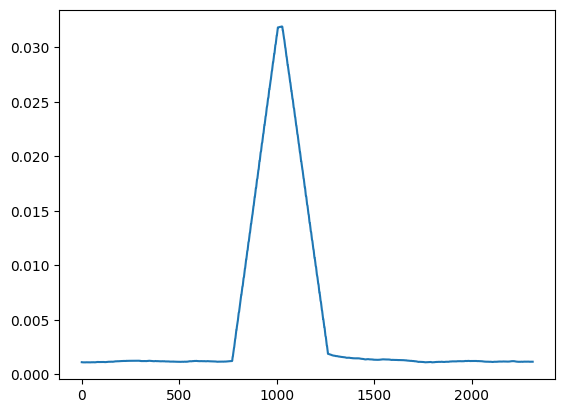

In [13]:
# floating window - to find the threshold
window_len = N
relevant_signal = np.abs(samples[pmax-5*N : pmax + 5*N])
ma_signal = np.zeros((relevant_signal.size - N + 1), dtype=float)
for i in range(ma_signal.size):
    for j in range(N):
        ma_signal[i] += relevant_signal[i + j]
    ma_signal[i] /= N
plt.plot(ma_signal)
print(np.max(ma_signal))
pp = np.argmax(ma_signal).squeeze()
print(np.mean(ma_signal))
print(np.mean(np.delete(ma_signal, np.arange(pp - N//2 - 1, pp + N//2 + 1))))
# plt.yscale("log")